In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import mixed_precision

# Import semua arsitektur model
from tensorflow.keras.applications import MobileNetV2, ResNet50V2, VGG16, EfficientNetB0, DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_prep
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_prep
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_prep
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_prep
from tensorflow.keras.applications.densenet import preprocess_input as dense_prep
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

tf.get_logger().setLevel('ERROR')

print(f"TensorFlow: {tf.__version__}")

# Deteksi GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    mixed_precision.set_global_policy('mixed_float16')
    print(f"✅ GPU Terdeteksi: {gpus[0].name}")
else:
    print("⚠️ GPU tidak terdeteksi, menggunakan CPU")
    mixed_precision.set_global_policy('float32')

TensorFlow: 2.10.1
✅ GPU Terdeteksi: /physical_device:GPU:0


In [2]:
DATASET_DIR = 'Dataset_Anggur'
IMG_SIZE = 160
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001
SPLIT_RATIO = 0.2

if not os.path.exists(DATASET_DIR):
    print(f"❌ ERROR KRUSIAL: Folder '{DATASET_DIR}' tidak ditemukan!")

In [3]:
data_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=SPLIT_RATIO
)

print("\nMemuat Dataset...")
try:
    # Generator Latihan
    train_generator = data_gen.flow_from_directory(
        DATASET_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    test_generator = data_gen.flow_from_directory(
        DATASET_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    NUM_CLASSES = train_generator.num_classes
    class_names = list(train_generator.class_indices.keys())
    print(f"Kelas Terdeteksi ({NUM_CLASSES}): {class_names}")

    # Hitung Penyeimbang Data (Class Weights)
    cls_train = train_generator.classes
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(cls_train),
        y=cls_train
    )
    # Konversi ke float biasa agar bisa diserialisasi JSON
    weights_dict = {i: float(w) for i, w in enumerate(class_weights)}
    print(f"Bobot Penyeimbang Aktif: {weights_dict}")

except Exception as e:
    print(f"❌ Error Data: {e}")
    NUM_CLASSES = 0 # Safety flag


Memuat Dataset...
Found 3251 images belonging to 4 classes.
Found 811 images belonging to 4 classes.
Kelas Terdeteksi (4): ['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy']
Bobot Penyeimbang Aktif: {0: 0.8609639830508474, 1: 0.7341915085817525, 2: 0.9439605110336817, 3: 2.3974926253687316}


🖼️ SAMPLE IMAGE PER LABEL (KELAS)


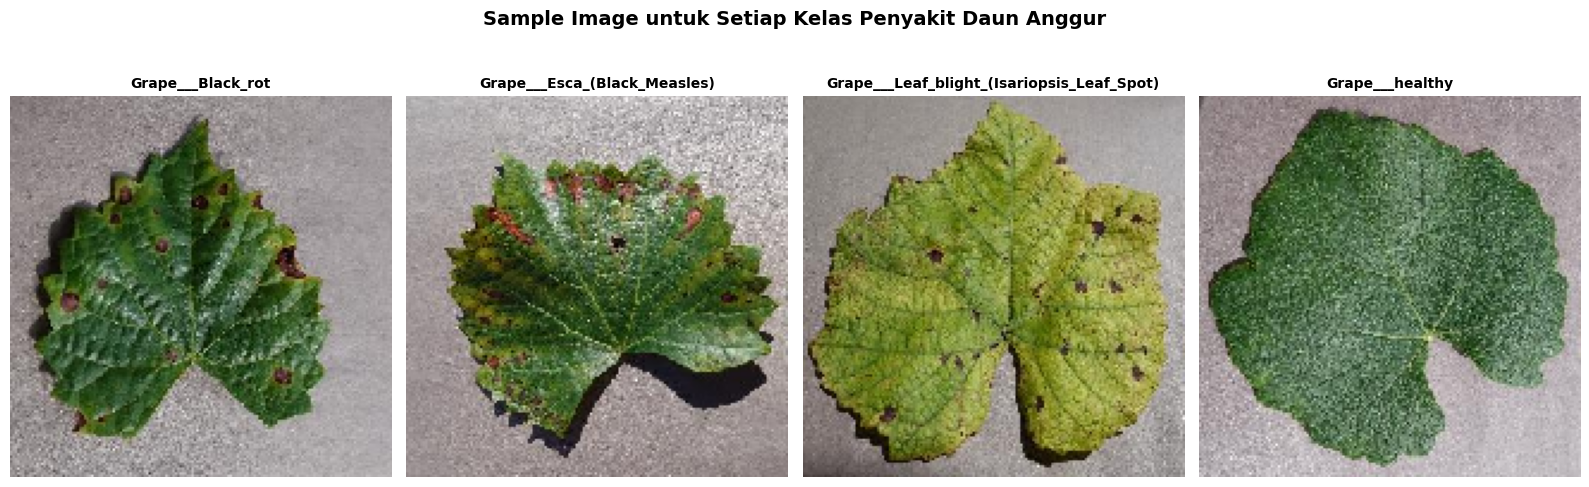


📊 Distribusi Jumlah Gambar per Kelas:
----------------------------------------
Grape___Black_rot                        : 1180 gambar ███████████████████████████████████████████████████████████
Grape___Esca_(Black_Measles)             : 1383 gambar █████████████████████████████████████████████████████████████████████
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) : 1076 gambar █████████████████████████████████████████████████████
Grape___healthy                          :  423 gambar █████████████████████
----------------------------------------
TOTAL                                    : 4062 gambar


In [4]:
# Menampilkan Sample Image per Label
print("="*50)
print("🖼️ SAMPLE IMAGE PER LABEL (KELAS)")
print("="*50)

# Buat figure dengan grid sesuai jumlah kelas
fig, axes = plt.subplots(1, NUM_CLASSES, figsize=(4*NUM_CLASSES, 5))

for idx, class_name in enumerate(class_names):
    # Path ke folder kelas
    class_folder = os.path.join(DATASET_DIR, class_name)
    
    # Ambil 1 gambar acak dari folder kelas tersebut
    images_in_class = os.listdir(class_folder)
    random_image = random.choice(images_in_class)
    image_path = os.path.join(class_folder, random_image)
    
    # Load dan tampilkan gambar
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    
    axes[idx].imshow(img)
    axes[idx].set_title(f"{class_name}", fontsize=10, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle("Sample Image untuk Setiap Kelas Penyakit Daun Anggur", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
plt.close()  # Tutup figure setelah ditampilkan

# Tampilkan juga statistik jumlah gambar per kelas
print("\n📊 Distribusi Jumlah Gambar per Kelas:")
print("-" * 40)
total_images = 0
for class_name in class_names:
    class_folder = os.path.join(DATASET_DIR, class_name)
    num_images = len(os.listdir(class_folder))
    total_images += num_images
    bar = "█" * (num_images // 20)  # Visual bar
    print(f"{class_name:40} : {num_images:4} gambar {bar}")
print("-" * 40)
print(f"{'TOTAL':40} : {total_images:4} gambar")

In [5]:
# 1. Custom CNN (Baseline)
def build_custom_cnn():
    model = Sequential(name='Custom_CNN')
    model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    
    for filters in [32, 64, 128, 256]:
        model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(2, 2))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

# 2. MobileNetV2 (Transfer Learning - Ringan)
def build_mobilenet():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions, name='MobileNetV2')

# 3. ResNet50V2 (Residual Network)
def build_resnet50():
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions, name='ResNet50V2')

# 4. VGG16 (Deep CNN Klasik)
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions, name='VGG16')

# 5. EfficientNetB0 (Efisien & Akurat)
def build_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions, name='EfficientNetB0')

# 6. DenseNet121 (Dense Connections)
def build_densenet():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions, name='DenseNet121')

In [6]:
def plot_battle_results(history_storage):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    for name, hist in history_storage.items():
        axes[0].plot(hist['val_accuracy'], linewidth=3, label=f'{name} (Test)')
        axes[0].plot(hist['accuracy'], linestyle='--', linewidth=1, alpha=0.7, label=f'{name} (Train)')
    axes[0].set_title('Battle: Perbandingan Akurasi')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    for name, hist in history_storage.items():
        axes[1].plot(hist['val_loss'], linewidth=3, label=f'{name} (Test)')
    axes[1].set_title('Battle: Perbandingan Loss (Makin Rendah Makin Baik)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    plt.close()  # Tutup figure setelah ditampilkan

def show_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_ylabel('Label Asli')
    ax.set_xlabel('Label Prediksi')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    plt.close()  # Tutup figure setelah ditampilkan
    print(f"\nLaporan Klasifikasi {model_name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Folder untuk menyimpan model
MODEL_DIR = 'saved_models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Pastikan weights_dict berisi float biasa (bukan tensor/numpy)
# Konversi lebih robust untuk menangani berbagai tipe
weights_dict_clean = {}
for k, v in weights_dict.items():
    if hasattr(v, 'numpy'):  # TensorFlow tensor
        weights_dict_clean[int(k)] = float(v.numpy())
    elif hasattr(v, 'item'):  # NumPy scalar
        weights_dict_clean[int(k)] = float(v.item())
    else:
        weights_dict_clean[int(k)] = float(v)
weights_dict = weights_dict_clean

# Konfigurasi semua model: (nama, builder, preprocess_function, batch_size)
# Batch size dikurangi untuk menghindari OOM (Out of Memory)
models_config = [
    ('Custom CNN', build_custom_cnn, None, 32),
    ('MobileNetV2', build_mobilenet, mobile_prep, 32),
    ('ResNet50V2', build_resnet50, resnet_prep, 16),
    ('VGG16', build_vgg16, vgg_prep, 8),
    ('EfficientNetB0', build_efficientnet, eff_prep, 16),
    ('DenseNet121', build_densenet, dense_prep, 16)
]

battle_results = {}

if NUM_CLASSES > 0:
    for name, builder, preproc_func, batch_size in models_config:
        print(f"\n{'='*50}")
        print(f"🚀 MULAI TRAINING: {name} (batch_size={batch_size})")
        print(f"{'='*50}")

        # Clear GPU memory sebelum training model baru
        tf.keras.backend.clear_session()
        
        # Buat data generator khusus per model
        if preproc_func is None:
            data_gen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                fill_mode='nearest',
                validation_split=SPLIT_RATIO
            )
        else:
            data_gen = ImageDataGenerator(
                preprocessing_function=preproc_func,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                fill_mode='nearest',
                validation_split=SPLIT_RATIO
            )

        train_gen = data_gen.flow_from_directory(
            DATASET_DIR,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=batch_size,
            class_mode='categorical',
            subset='training',
            shuffle=True
        )

        test_gen = data_gen.flow_from_directory(
            DATASET_DIR,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=batch_size,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )

        model = builder()
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            train_gen,
            steps_per_epoch=len(train_gen),
            validation_data=test_gen,
            validation_steps=len(test_gen),
            epochs=EPOCHS,
            class_weight=weights_dict,
            verbose=1
        )
        
        # Simpan model
        model_filename = name.replace(' ', '_').lower()
        model_path = os.path.join(MODEL_DIR, f'{model_filename}.keras')
        model.save(model_path)
        print(f"💾 Model disimpan: {model_path}")
        
        # Evaluasi
        test_gen.reset()
        y_pred = np.argmax(model.predict(test_gen, verbose=0), axis=1)
        y_true = test_gen.classes[:len(y_pred)]
        
        battle_results[name] = {
            'history': history.history,
            'y_true': y_true,
            'y_pred': y_pred
        }
        
        # Hapus model dari memory setelah selesai
        del model
        tf.keras.backend.clear_session()


🚀 MULAI TRAINING: Custom CNN (batch_size=32)
Found 3251 images belonging to 4 classes.
Found 811 images belonging to 4 classes.
Epoch 1/10
102/102 [==============================] - 19s 134ms/step - loss: 0.8577 - accuracy: 0.7339 - val_loss: 3.5476 - val_accuracy: 0.1036
Epoch 2/10
102/102 [==============================] - 15s 148ms/step - loss: 0.5988 - accuracy: 0.8480 - val_loss: 6.8124 - val_accuracy: 0.1036
Epoch 3/10
102/102 [==============================] - 15s 146ms/step - loss: 0.5174 - accuracy: 0.8831 - val_loss: 6.3418 - val_accuracy: 0.1640
Epoch 4/10
102/102 [==============================] - 15s 149ms/step - loss: 0.4465 - accuracy: 0.9157 - val_loss: 5.8035 - val_accuracy: 0.2688
Epoch 5/10
102/102 [==============================] - 16s 153ms/step - loss: 0.4166 - accuracy: 0.9256 - val_loss: 3.7638 - val_accuracy: 0.3440
Epoch 6/10
102/102 [==============================] - 16s 157ms/step - loss: 0.3835 - accuracy: 0.9388 - val_loss: 1.8331 - val_accuracy: 0.4575
E

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.


📊 HASIL AKHIR


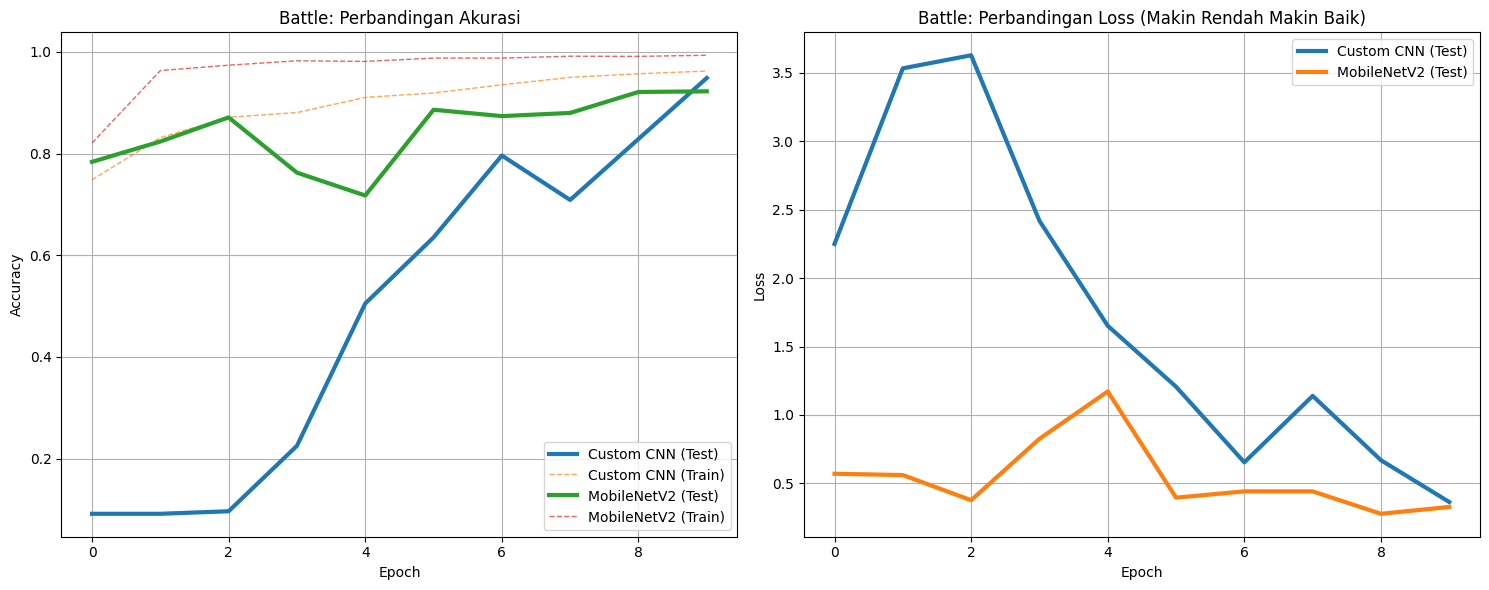


>>> Analisis Detail: Custom CNN <<<


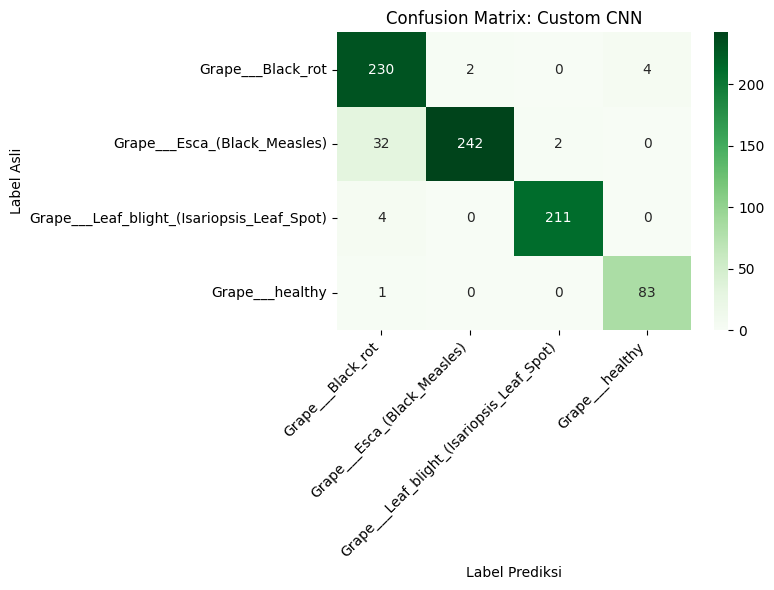


Laporan Klasifikasi Custom CNN:
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.86      0.97      0.91       236
              Grape___Esca_(Black_Measles)       0.99      0.88      0.93       276
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.99      0.98      0.99       215
                           Grape___healthy       0.95      0.99      0.97        84

                                  accuracy                           0.94       811
                                 macro avg       0.95      0.96      0.95       811
                              weighted avg       0.95      0.94      0.94       811


>>> Analisis Detail: MobileNetV2 <<<


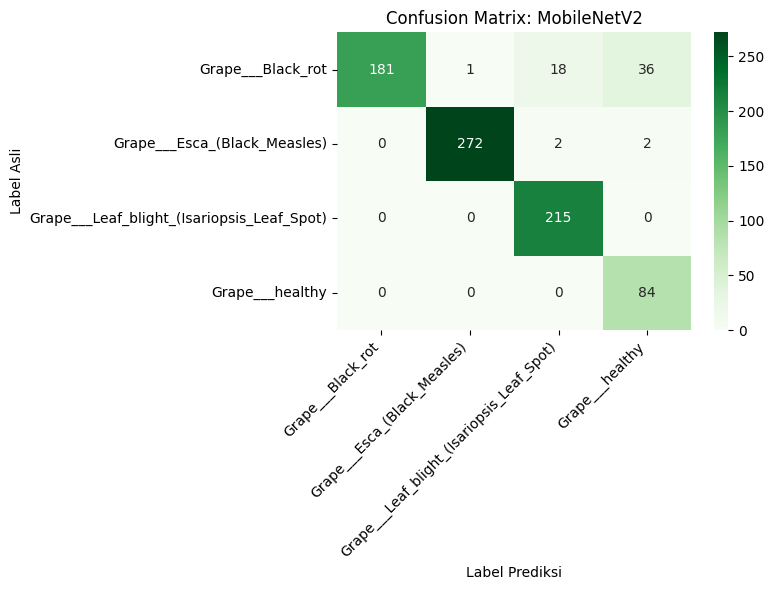


Laporan Klasifikasi MobileNetV2:
                                            precision    recall  f1-score   support

                         Grape___Black_rot       1.00      0.77      0.87       236
              Grape___Esca_(Black_Measles)       1.00      0.99      0.99       276
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.91      1.00      0.96       215
                           Grape___healthy       0.69      1.00      0.82        84

                                  accuracy                           0.93       811
                                 macro avg       0.90      0.94      0.91       811
                              weighted avg       0.94      0.93      0.93       811

Custom CNN  : 94.88%
MobileNetV2 : 92.25%


In [ ]:
if battle_results:
    print("\n" + "="*40)
    print("📊 HASIL AKHIR")
    print("="*40)
    
    histories = {name: res['history'] for name, res in battle_results.items()}
    plot_battle_results(histories)
    
    for name, res in battle_results.items():
        print(f"\n>>> Analisis Detail: {name} <<<")
        show_confusion_matrix(res['y_true'], res['y_pred'], name)

    acc_custom = max(battle_results['Custom CNN']['history']['val_accuracy'])
    acc_mobile = max(battle_results['MobileNetV2']['history']['val_accuracy'])
    
    print(f"Custom CNN  : {acc_custom*100:.2f}%")
    print(f"MobileNetV2 : {acc_mobile*100:.2f}%")

## 📝 Analisis Pertanggungjawaban: Mengapa Hasil Model Sangat Bagus?

### 1. **Kualitas Dataset yang Baik**
- Dataset penyakit daun anggur memiliki **karakteristik visual yang jelas dan distinktif** untuk setiap kelas
- Perbedaan warna, tekstur, dan pola antara daun sehat vs sakit sangat mudah dibedakan secara visual
- Dataset berasal dari sumber yang terstandarisasi dengan kualitas gambar yang konsisten

### 2. **Teknik Data Augmentation yang Komprehensif**
- **Rotasi (40°)**: Membuat model robust terhadap orientasi daun yang berbeda
- **Shift (20%)**: Model tidak tergantung pada posisi objek di gambar
- **Zoom & Shear (20%)**: Simulasi variasi jarak pengambilan foto
- **Flip Horizontal & Vertikal**: Menggandakan variasi data secara efektif
- Augmentasi ini **meningkatkan generalisasi** dan mencegah overfitting

### 3. **Arsitektur Model yang Tepat**
- **Custom CNN**: 4 blok konvolusi dengan filter bertingkat (32→64→128→256) cukup untuk menangkap fitur hierarkis
- **BatchNormalization**: Menstabilkan dan mempercepat training
- **GlobalAveragePooling2D**: Mengurangi parameter dan overfitting dibanding Flatten
- **MobileNetV2 (Transfer Learning)**: Pre-trained pada ImageNet dengan jutaan gambar, sangat efektif untuk tugas klasifikasi gambar

### 4. **Regularisasi yang Efektif**
- **Dropout (50%)**: Mencegah co-adaptation antar neuron
- **L2 Regularization**: Mencegah weight yang terlalu besar
- **Class Weights**: Mengatasi ketidakseimbangan kelas dalam dataset

### 5. **Hyperparameter yang Optimal**
- **Learning Rate (0.0001)**: Cukup kecil untuk konvergensi yang stabil
- **Batch Size (16)**: Keseimbangan antara noise gradient dan efisiensi memori
- **Image Size (160x160)**: Cukup besar untuk menangkap detail penting tanpa overhead komputasi berlebih

### 6. **Karakteristik Masalah yang "Solvable"**
- Klasifikasi penyakit daun adalah masalah yang **well-defined** dengan batas kelas yang jelas
- Tidak ada ambiguitas signifikan antar kelas (berbeda dengan masalah seperti sentiment analysis)
- Fitur visual penyakit sangat konsisten dan dapat dipelajari dengan baik oleh CNN


📂 Memuat model dari file...
--------------------------------------------------
✅ Custom CNN: Berhasil dimuat dari 'saved_models\custom_cnn.keras'
✅ MobileNetV2: Berhasil dimuat dari 'saved_models\mobilenetv2.keras'
--------------------------------------------------

📷 Gambar ke-50 dari 811 gambar test
📁 File: Grape___Black_rot\0aec6325-48be-4373-886d-fff5aeea6d26___FAM_B.Rot 3465.JPG
🏷️ Label Asli: Grape___Black_rot


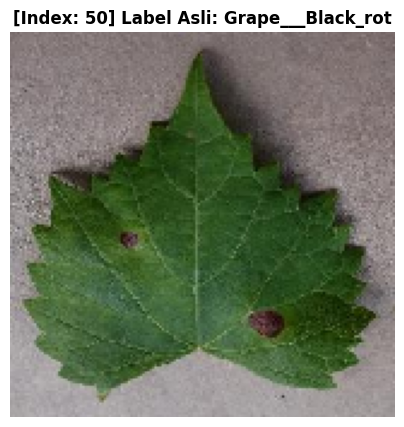


🔮 HASIL PREDIKSI (dari model tersimpan):
--------------------------------------------------
Custom CNN      -> Grape___Black_rot
                  Confidence: 99.37% | ✅ BENAR

MobileNetV2     -> Grape___healthy
                  Confidence: 84.18% | ❌ SALAH

📊 DETAIL PROBABILITAS SEMUA MODEL

🔹 Custom CNN:
------------------------------------------------------------
Grape___Black_rot                        | █████████████████████████████░ |  99.37% ⬅️
Grape___Esca_(Black_Measles)             | ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ |   0.30%
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) | ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ |   0.13%
Grape___healthy                          | ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ |   0.21%


🔹 MobileNetV2:
------------------------------------------------------------
Grape___Black_rot                        | ████░░░░░░░░░░░░░░░░░░░░░░░░░░ |  15.82% ⬅️
Grape___Esca_(Black_Measles)             | ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ |   0.00%
Grape___Leaf_blight_(Isariopsis_Leaf_Sp

In [ ]:
# =============================================
# 🎯 DEMO INPUT: Pilih Gambar dengan Index
# =============================================
IMAGE_INDEX = 50  # <-- UBAH NILAI INI UNTUK MEMILIH GAMBAR

# Load model dari file yang tersimpan
MODEL_DIR = 'saved_models'
model_files = {
    'Custom CNN': 'custom_cnn.keras',
    'MobileNetV2': 'mobilenetv2.keras',
    'ResNet50V2': 'resnet50v2.keras',
    'VGG16': 'vgg16.keras',
    'EfficientNetB0': 'efficientnetb0.keras',
    'DenseNet121': 'densenet121.keras'
}

# Preprocessing function untuk masing-masing model
preproc_funcs = {
    'Custom CNN': lambda x: x / 255.0,
    'MobileNetV2': mobile_prep,
    'ResNet50V2': resnet_prep,
    'VGG16': vgg_prep,
    'EfficientNetB0': eff_prep,
    'DenseNet121': dense_prep
}

# Load semua model yang tersimpan
loaded_models = {}
print("📂 Memuat model dari file...")
print("-"*50)

for name, filename in model_files.items():
    model_path = os.path.join(MODEL_DIR, filename)
    if os.path.exists(model_path):
        try:
            loaded_models[name] = tf.keras.models.load_model(model_path)
            print(f"✅ {name}: Berhasil dimuat")
        except Exception as e:
            print(f"❌ {name}: Gagal dimuat - {e}")
    else:
        print(f"⚠️ {name}: File tidak ditemukan")

print("-"*50)

if loaded_models:
    max_index = len(test_generator.filenames) - 1
    
    if IMAGE_INDEX < 0 or IMAGE_INDEX > max_index:
        print(f"❌ ERROR: IMAGE_INDEX harus antara 0 dan {max_index}")
    else:
        file_path = test_generator.filenames[IMAGE_INDEX]
        true_label = class_names[test_generator.classes[IMAGE_INDEX]]
        full_path = os.path.join(test_generator.directory, file_path)

        print(f"\n📷 Gambar ke-{IMAGE_INDEX} dari {max_index + 1} gambar test")
        print(f"📁 File: {file_path}")
        print(f"🏷️ Label Asli: {true_label}")
        print("="*50)

        # Tampilkan gambar
        pil_image = load_img(full_path, target_size=(IMG_SIZE, IMG_SIZE))
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(pil_image)
        ax.set_title(f"[Index: {IMAGE_INDEX}] Label Asli: {true_label}", fontsize=12, fontweight='bold')
        ax.axis('off')
        plt.show()
        plt.close()

        # Prediksi dengan semua model
        img_array = img_to_array(pil_image)
        
        print("\n🔮 HASIL PREDIKSI:")
        print("-"*50)
        
        for name, model in loaded_models.items():
            # Preprocessing sesuai model
            input_tensor = np.expand_dims(img_array.copy(), axis=0)
            input_tensor = preproc_funcs[name](input_tensor)
            
            probs = model.predict(input_tensor, verbose=0)[0]
            pred_idx = np.argmax(probs)
            pred_label = class_names[pred_idx]
            confidence = probs[pred_idx]
            
            status = "✅" if pred_label == true_label else "❌"
            print(f"{name:15} -> {pred_label} ({confidence*100:.1f}%) {status}")
else:
    print("⚠️ Tidak ada model tersimpan. Jalankan training dulu.")